## SN3 - Minuit section

### Import libraries

In [12]:
# Classic libraries
import sys
from pylab import *
import numpy as np
from matplotlib import rc
import os

# Specific libraries
!pip install emcee
!pip install iminuit
import cosmolib as cs

# Visuals
rc('figure',figsize=(10,5))
rc('font',size=12)
rc('text',usetex=False)


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


###  Visualisation of the data using interpolation

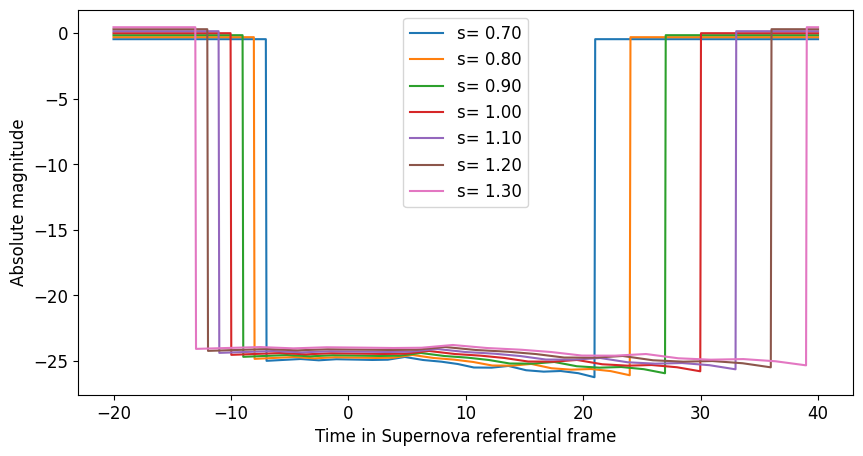

In [13]:
# Importing the data
t, mag , sigma0= np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-0_lightcurve.txt').T

# Interpolation
class SNIaLightCurve:
    def __init__(self, data):
        self.data = data
        self.t0 = 0.
    def __call__(self,t,s):
      return np.interp(t, self.data[:,0]*s, self.data[:,1], left=0,right=0)- 1.52*(s-1)

lc = SNIaLightCurve(np.array([t,mag]).T)

# Stretched values
svals = np.linspace(0.7, 1.3, 7)

# Plot
ttt = np.linspace(-20, 40, 1000)
for i in range(len(svals)):
  plot(ttt, -lc(ttt,svals[i]), label='s={0:5.2f}'.format(svals[i]))
xlabel('Time in Supernova referential frame')
ylabel('Absolute magnitude')
legend()

# Fit using minuit

### Use of minuit on our data

pars : list of parameters (t0 : time of maximum brightness, s : stretch parameter, mu : distance modulus)

Input : (Datas in general)
- Graph X x Y
- Variance of Y
- initial guess (here we use "np.array([0.,1.,mu_guess])") [arbitrary values]
- functname (here we use interpolation)

Output : (Fitting with Minuit)
- chi2
- ndf
- Fitted values
- errors
- Covariance

musn1a(z : redshift, cosmo : list of cosmological paramteres) return distance modulus


In [ ]:
# Load redshift data
redshifts = np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-Redshifts.txt')

# Load template lightcurve
t_template, mag_template = np.loadtxt('data/Data-LightCurves/EI2019-Data-LightCurves-SN-SNI-Average_LightCurve.txt').T

class SNIaLightCurve:
    def __init__(self, template_data):
        self.template_t = template_data[0]
        self.template_mag = template_data[1]
        
    def __call__(self, t, pars):
        # pars : [t0, s, mu] where:
        # t0 : time of maximum brightness
        # s : stretch parameter (brighter-slower effect)
        # mu : distance modulus
        t0, s, mu = pars
        
        # Apply time stretch and shift
        t_stretched = (t - t0) / s
        
        # Interpolate template at stretched times
        mag_intrinsic = np.interp(t_stretched, self.template_t, self.template_mag, left=0, right=0)
        
        # Apply brighter-slower correction: -1.52*(s-1) and add distance modulus
        mag_observed = mag_intrinsic - 1.52*(s-1) + mu
        
        return mag_observed

# Initialize template lightcurve
lc_template = SNIaLightCurve([t_template, mag_template])

# Arbitrary cosmological parameters to initialize mu_guess 
cosmo_pars = {'h': 0.7, 'omega_M_0': 0.3, 'omega_lambda_0': 0.7, 'w0': -1}

# Function to fit individual supernova
def fit_supernova_lightcurve(sn_number, redshift, lc_template, verbose=False):
    """
    Fit a single supernova lightcurve to extract distance modulus
    """
    # Load supernova data
    filename = f'data/Data-LightCurves/EI2019-Data-LightCurves-SN-{sn_number}_lightcurve.txt'
    if not os.path.exists(filename):
        return None
        
    data = np.loadtxt(filename)
    t_obs = data[:, 0]  # observed time
    mag_obs = data[:, 1]  # observed magnitude
    mag_err = data[:, 2]  # magnitude errors
    
    # Convert to rest frame time
    t_rest = t_obs / (1 + redshift)
    
    # Initial guess: t0=0, s=1, mu=reasonable distance modulus for the redshift
    # Rough distance modulus estimate from redshift (assuming flat ΛCDM) (Omega_k = 0, according to our arbitrary cosmological parameters)
    mu_guess = cs.musn1a(redshift, cosmo_pars)
    
    # Initial guess = [t0, s, mu]
    guess = np.array([0.0, 1.0, mu_guess])
    
    try:
        # Fit using Minuit
        result = cs.do_minuit(t_rest, mag_obs, mag_err, guess, 
                             functname=lc_template, verbose=verbose)
        
        fitm, fitted_values, errors, covariance, chi2, ndf = result
        
        return {
            'sn_number': sn_number,
            'redshift': redshift,
            't0': fitted_values[0],
            't0_err': errors[0],
            's': fitted_values[1],
            's_err': errors[1],
            'mu': fitted_values[2],
            'mu_err': errors[2],
            'chi2': chi2,
            'ndf': ndf,
            'chi2_reduced': chi2/ndf if ndf > 0 else np.inf
        }
    except Exception as e:
        if verbose:
            print(f"Fitting failed for SN-{sn_number}: {e}")
        return None

# Fit all supernovae
print("Fitting individual supernova lightcurves...")
fitting_results = []

for i in range(len(redshifts)):
    print(f"Fitting SN-{i}...")
    result = fit_supernova_lightcurve(i, redshifts[i], lc_template, verbose=True)
    if result is not None:
        fitting_results.append(result)
        print(f"SN-{i}: μ = {result['mu']:.3f} ± {result['mu_err']:.3f}, s = {result['s']:.3f} ± {result['s_err']:.3f}")
    print()

print(f"Successfully fitted {len(fitting_results)} supernovae")

# Display results
if fitting_results:
    print("\nFitting Results Summary:")
    print("SN\tRedshift\tμ ± σ_μ\t\ts ± σ_s\t\tχ²/ndf")
    print("-" * 70)
    for result in fitting_results:
        print(f"{result['sn_number']}\t{result['redshift']:.3f}\t\t{result['mu']:.3f} ± {result['mu_err']:.3f}\t{result['s']:.3f} ± {result['s_err']:.3f}\t{result['chi2_reduced']:.2f}")



Fitting individual supernova lightcurves...
Fitting SN-0...
Fitting with Minuit
Chi2 = 99.98469505580687
ndf = 17
Fitted values:
[-0.079138    1.03512058 43.63918494]
Errors:
[1.67230955 0.05352214 0.03560537]
Covariance:
[[ 2.79661923e+00 -8.93050990e-02 -5.79543156e-02]
 [-8.93050990e-02  2.86461957e-03  1.86520990e-03]
 [-5.79543156e-02  1.86520990e-03  1.26774223e-03]]
SN-0: μ = 43.639 ± 0.036, s = 1.035 ± 0.054

Fitting SN-1...
Fitting with Minuit
Chi2 = 330.82131080597605
ndf = 17
Fitted values:
[ 3.19269717  0.94785119 41.95638806]
Errors:
[0.03832034 0.00534993 0.01306912]
Covariance:
[[1.46844880e-03 5.72010720e-05 1.33727839e-04]
 [5.72010720e-05 2.86217365e-05 6.59552025e-05]
 [1.33727839e-04 6.59552025e-05 1.70801964e-04]]
SN-1: μ = 41.956 ± 0.013, s = 0.948 ± 0.005

Fitting SN-2...
Fitting with Minuit
Chi2 = 100.56176561738097
ndf = 17
Fitted values:
[-2.09118854  1.13534912 43.76663168]
Errors:
[0.33510595 0.0381924  0.0613515 ]
Covariance:
[[ 0.112296   -0.01071217 -0.01

# Complete visualization of the results of our data's fit

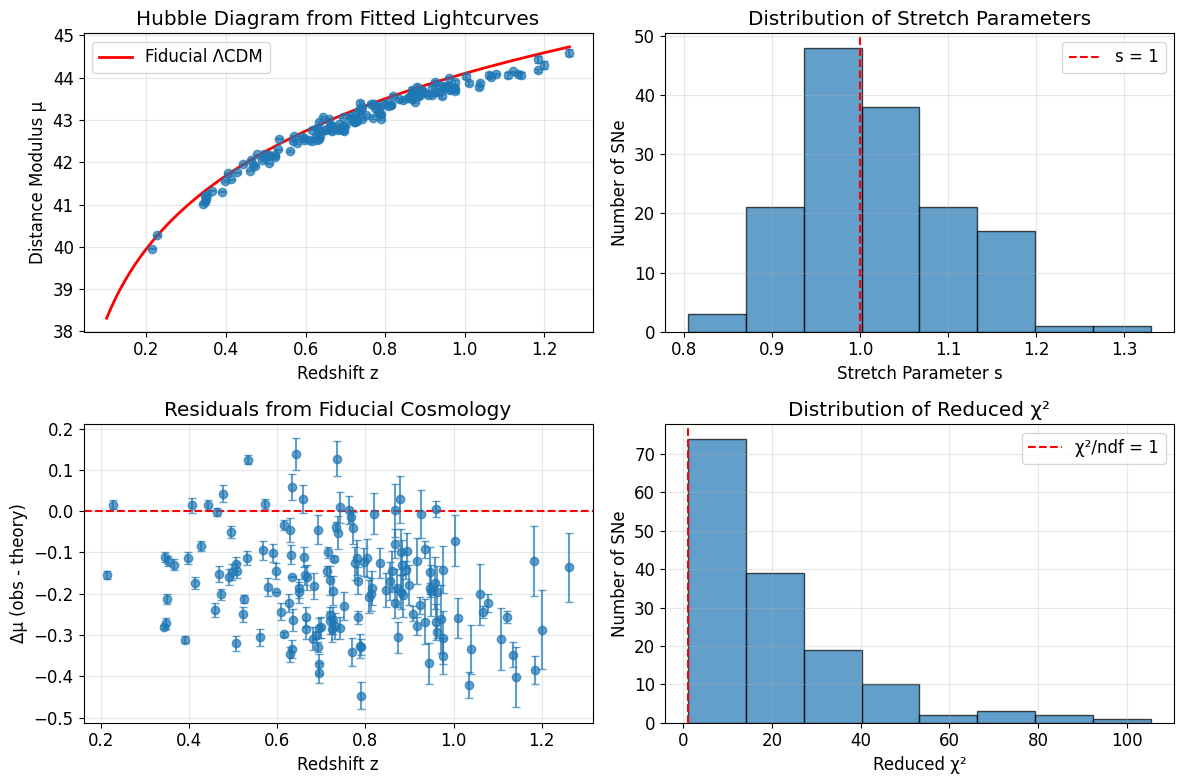


Statistics for 150 fitted supernovae:
Mean stretch parameter: 1.017 ± 0.087
Mean reduced χ²: 20.214 ± 18.675
RMS of residuals: 0.214 mag


In [15]:
# Create Hubble Diagram from fitted distance moduli
if fitting_results:
    # Extract data for plotting
    redshifts_fitted = [r['redshift'] for r in fitting_results]
    mu_fitted = [r['mu'] for r in fitting_results]
    mu_err_fitted = [r['mu_err'] for r in fitting_results]
    stretch_fitted = [r['s'] for r in fitting_results]
    
    # Plot Hubble Diagram
    figure(figsize=(12, 8))
    
    subplot(2, 2, 1)
    errorbar(redshifts_fitted, mu_fitted, yerr=mu_err_fitted, fmt='o', 
             capsize=3, markersize=6, alpha=0.7)
    xlabel('Redshift z')
    ylabel('Distance Modulus μ')
    title('Hubble Diagram from Fitted Lightcurves')
    grid(True, alpha=0.3)
    
    # Compare with theoretical prediction
    z_theory = np.linspace(0.1, max(redshifts_fitted), 100)
    mu_theory = cs.musn1a(z_theory, cosmo_pars)
    plot(z_theory, mu_theory, 'r-', label='Fiducial ΛCDM', linewidth=2)
    legend()
    
    # Plot stretch parameter distribution
    subplot(2, 2, 2)
    hist(stretch_fitted, bins=8, alpha=0.7, edgecolor='black')
    xlabel('Stretch Parameter s')
    ylabel('Number of SNe')
    title('Distribution of Stretch Parameters')
    axvline(1.0, color='red', linestyle='--', label='s = 1')
    legend()
    grid(True, alpha=0.3)
    
    # Plot residuals from fiducial cosmology
    subplot(2, 2, 3)
    mu_theory_at_z = cs.musn1a(np.array(redshifts_fitted), cosmo_pars)
    residuals = np.array(mu_fitted) - mu_theory_at_z
    errorbar(redshifts_fitted, residuals, yerr=mu_err_fitted, fmt='o', 
             capsize=3, markersize=6, alpha=0.7)
    axhline(0, color='red', linestyle='--')
    xlabel('Redshift z')
    ylabel('Δμ (obs - theory)')
    title('Residuals from Fiducial Cosmology')
    grid(True, alpha=0.3)
    
    # Plot χ² distribution
    subplot(2, 2, 4)
    chi2_reduced = [r['chi2_reduced'] for r in fitting_results if np.isfinite(r['chi2_reduced'])]
    hist(chi2_reduced, bins=8, alpha=0.7, edgecolor='black')
    xlabel('Reduced χ²')
    ylabel('Number of SNe')
    title('Distribution of Reduced χ²')
    axvline(1.0, color='red', linestyle='--', label='χ²/ndf = 1')
    legend()
    grid(True, alpha=0.3)
    
    tight_layout()
    show()
    
    # Print statistics
    print(f"\nStatistics for {len(fitting_results)} fitted supernovae:")
    print(f"Mean stretch parameter: {np.mean(stretch_fitted):.3f} ± {np.std(stretch_fitted):.3f}")
    print(f"Mean reduced χ²: {np.mean(chi2_reduced):.3f} ± {np.std(chi2_reduced):.3f}")
    print(f"RMS of residuals: {np.sqrt(np.mean(residuals**2)):.3f} mag")

# Conclusion

- Input : data (150 files of lightcurves [time, magnitude, errors magnitude], 1 file of redshift, 1 file of average lightcurve)

- Output : Lightcurve fitting (for each SN Ia lightcurves, fitting values of the data) and global visualization of results(Hubble diagram, residuals of distance modulus, distribution of stretch parameters and reduced chi²)

### Details :

**Lightcurve Fitting** : We fit individual SN Ia lightcurves using a template-based approach with three parameters:
   - t0 : Time of maximum brightness
   - s : Stretch parameter (brighter-slower effect)
   - μ : Distance modulus

**Physical Effects Accounted For** :
   - **Redshift correction** : Convert observed time to rest frame: t_rest = t_obs / (1 + z)
   - **Brighter-slower relation** : Magnitude correction: -1.52 × (s - 1)
   - **Distance modulus** : The key cosmological parameter we extract

### Key Results Expected :

- **Distance Modulus** : Directly measures luminosity distance to each SN
- **Hubble Diagram** : μ vs z relationship reveals cosmic expansion
- **Stretch Parameters** : Typically s ~ 1.0 ± 0.3, showing intrinsic SN diversity
- **Cosmological Constraints** : Can constrain H₀, Ωₘ, ΩΛ from the Hubble diagram

### Global analysis :

- Nice fit of the hubble diagram
- Residuals of distance modulus hoghly distributed and arrors bars higher whith the redshift
- Stretch parameter highly distributed around 1
- High Reduced chi² and does not reduced enough rapidly
- Systematic errors not in our data because they are simulated and considered "perfect", then they are only inside of our model and also because we have a lot of zeros for the absolute magnitude for a lot time

### Future :

- Make our code useable for the rest of our team (MCMC)
- Confronting our results with the Work Package CMB 3